# Decision trees and random forest

In [1]:
# WARNING: EXPENSIVE COMPUTING IF RUN_CALCULATION = True
# Calculation has already been done and saved in FILEPATH file and are reloaded from the file in this notebook
RUN_CALCULATION       = False
TREE_GRID_FILEPATH    = 'saved_grid_search_results/decision_tree_grid.npy'
FOREST_GRID_FILEPATH  = 'saved_grid_search_results/random_forest_grid.npy'
TREE_MODEL_FILEPATH   = 'saved_best_models/decision_tree_model.npy'
FOREST_MODEL_FILEPATH = 'saved_best_models/random_forest_model.npy'

In [2]:
# Import functions used in the different notebooks of the course project
%run Tools.ipynb

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid, StratifiedShuffleSplit

## 1. Load & Split Datasets

In [4]:
# Load the overfeat dataset
overfeat, _, labels, names = load_data()

# Check shapes
print('Overfeat shape:', overfeat.shape)
print('Labels shape:', labels.shape)

Overfeat shape: (5000, 4096)
Labels shape: (5000,)


In [5]:
# Split the train/test sets (4000/1000 stratified split)
X_train, X_test, y_train, y_test = split_data_stratified(overfeat, labels)
print('Train shape:', X_train.shape, y_train.shape)
print('Test shape:', X_test.shape, y_test.shape)

# Check the classes distribution in the test set
print('\nTest Classes Distribution:')
pd.value_counts(names[y_test])

Train shape: (4000, 4096) (4000,)
Test shape: (1000, 4096) (1000,)

Test Classes Distribution:


truck       250
ship        250
car         250
airplane    250
dtype: int64

## 2. Decision Tree

Decision trees tend to quickly overfit the training data as its depth increase. Because trees segment the predictor space into a number of regions, we can expect that applying PCA to reduce the number of dimensions of this space by building higher level predictors and keep a huge proportion of the original variance should be profitable for the accuracy of our predictions. So, for this simple decision tree model, we will just keep 90% of the variance by using 176 PCA components and try to find the best tree depth in the [1, 20] range by applying grid search. 

The task asks to don't use cross-validation. Instead, we will use the validation set approach, i.e., randomly splitting the training/validation sets multiple times and compute the model on each split for each hyperparameters. Note that this approach is less efficient than cross-validation because the variability of the validation curves obtained for each train/validation sets splits. Averaging the curves, improve of course the results but we will tend to overestimate the test error (underestimate the test accuracy) because each time, the model is trained with a part of the overall data without guarantee to see all of them as it is the case for cross-validation that see each data (k-1) times. 

In [6]:
# Hyperparameters
dt__max_depth = np.arange(1, 21)

# Grid search calculation if not already computed previously or forced
if RUN_CALCULATION | (os.path.exists(TREE_GRID_FILEPATH) == False):
    
    # Pipeline estimator
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=176, random_state=0)),  # 90% variance
        ('dt', DecisionTreeClassifier(criterion='gini', random_state=0))
    ])

    # Grid parameters
    grid = ParameterGrid(
        {
            'dt__max_depth': dt__max_depth
        } 
    )

    # Stratified Shuffle Split
    sss = StratifiedShuffleSplit(n_splits=10, test_size=800, random_state=0)

    # Progres status variables
    n_steps = len(grid)
    i = 1

    # Grid Search
    scores = []
    for params_dict in grid:
    
        # print progress status
        print('{} | {}/{} : max depth = {}'.format(
            datetime.datetime.now().time(), 
            i, 
            n_steps,
            params_dict['dt__max_depth']))
    
        i += 1
    
        # set hyperparameters
        pipe.set_params(**params_dict)
    
        # validation set approach
        train_accuracy = []
        validation_accuracy = []
        for idx_train, idx_valid in sss.split(X_train, y_train):
        
            # training set
            X = X_train[idx_train]
            y = y_train[idx_train]
        
            # validation set
            X_valid = X_train[idx_valid]
            y_valid = y_train[idx_valid]
        
            # fit model
            pipe.fit(X, y)
    
            # train accuracy
            train_accuracy.append(pipe.score(X, y))
    
            # validation accuracy
            validation_accuracy.append(pipe.score(X_valid, y_valid))
    
        # Compute the mean of the accuracies obtained on each split
        params_dict['training_accuracy']   = np.mean(train_accuracy)
        params_dict['training_std'] = np.std(train_accuracy)
        params_dict['validation_accuracy'] = np.mean(validation_accuracy) 
        params_dict['validation_std'] = np.std(validation_accuracy)
        
        # accuracy difference
        params_dict['delta accuracy'] = params_dict['training_accuracy'] - params_dict['validation_accuracy']
    
        # save results with hyperparameters 
        scores.append(params_dict)
    
    # Save results in a numpy file
    np.save(TREE_GRID_FILEPATH, scores)
else:
    # Load the grid scores results from file
    scores = list(np.load(TREE_GRID_FILEPATH, allow_pickle=True))

In [7]:
# Create a DataFrame to analyze the grid search results
df = pd.DataFrame(scores)

# Show the hyperparameters for the best validation accuracy
df_best_scores = df.sort_values(by='validation_accuracy', ascending=False)
df_best_scores.head(20)

,delta accuracy,dt__max_depth,training_accuracy,training_std,validation_accuracy,validation_std
4,0.050406,5,0.712406,0.006617,0.662000,0.012135
5,0.100719,6,0.754844,0.006843,0.654125,0.019252
3,0.020062,4,0.673937,0.004473,0.653875,0.012418
6,0.153312,7,0.803937,0.007755,0.650625,0.016281
2,0.008219,3,0.645469,0.005843,0.637250,0.024474
7,0.221187,8,0.857812,0.009178,0.636625,0.008442
8,0.278375,9,0.904375,0.008375,0.626000,0.015246
1,0.005344,2,0.624594,0.006162,0.619250,0.020813
9,0.322500,10,0.938500,0.006907,0.616000,0.015800
10,0.352469,11,0.961344,0.006851,0.608875,0.014147


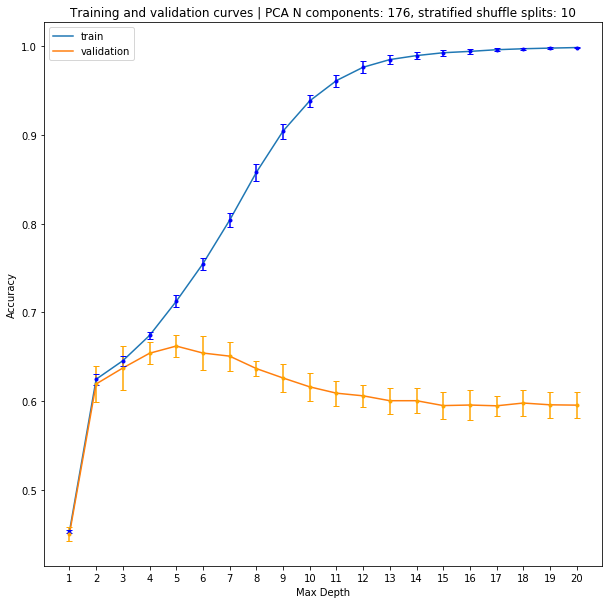

In [8]:
# Plot the training and validation curves
plt.figure(figsize=(10, 10))
plt.plot(df.dt__max_depth, df.training_accuracy, label='train')
plt.plot(df.dt__max_depth, df.validation_accuracy, label='validation')
plt.errorbar(df.dt__max_depth, df.training_accuracy, df.training_std, linestyle='None', marker='.', capsize=3, color='blue', label=None)
plt.errorbar(df.dt__max_depth, df.validation_accuracy, df.validation_std, linestyle='None', marker='.', capsize=3, color='orange', label=None)
plt.title('Training and validation curves | PCA N components: 176, stratified shuffle splits: 10')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 21))
plt.legend()
plt.show()

As we can see, the tree overfit quickly the training data and we see that the optimum depth is around 5. The error bar shows the variability of the validation curves. Lack of robustness is one of the disadvantage of decision trees, small change in data can cause a large change in the final estimated tree. Overall, we have an accuracy around 65% that is clearly less good than the 78% obtained with our kNN model. Random forest will help us to solve these two issues...

Which hyperparameter should we use for this model ?
* depth = 5 => best validation accuracy with 66.2% but a difference of 5% with the training accuracy (overfitting)
* depth = 4 => 65.4% validation accuracy (loss 1%) but with a difference of 2% with the training accuracy
* depth = 3 => 63.7% validation accuracy (loss 2.5%) but with a difference of less than 1% with the training accuracy and error bar that shows an important variance at this depth

Personally, I would go for a decision tree with a depth of 4 as it looks like a good compromise, but without the huge standard deviation of the model with depth of 3, I would probably choose this one. The model with a depth of 5 is clearly overfitting the training data. 

To select the best model with code, let's build a function that return the model with the best accuracy but with a difference between the training and validation accuracies less than a threshold:

In [9]:
# function that return the model with the best validation accuracy
# with a difference between the training & validation accuracies less than a threshold
def best_model_from_delta_accuracy(models, threshold=0.025):
    best_model = None
    for model in models:
        delta = model['training_accuracy'] - model['validation_accuracy']
        if delta < threshold:
            if best_model:
                if model['validation_accuracy'] > best_model['validation_accuracy']:
                    best_model = model
            else:
                best_model = model
                
    return best_model

In [10]:
# Get the best model with a difference of accuracy less than 2.5%
best_model = best_model_from_delta_accuracy(scores, threshold=0.025)

# Print the hyperparameters of the best model
print('Top accuracy on validation set: {:.3f} with depth: {}'.format(
    best_model['validation_accuracy'],
    best_model['dt__max_depth']
))

Top accuracy on validation set: 0.654 with depth: 4


### Decision tree accuracy on the test set

Decision tree accuracy on test set with these hyperparameters:
* PCA n components: 176
* Max depth: 4
* Criterion: Gini

In [11]:
if RUN_CALCULATION | (os.path.exists(TREE_MODEL_FILEPATH) == False):
    
    # Pipeline estimator
    tree_model = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=176, random_state=0)),
        ('dt', DecisionTreeClassifier(max_depth=best_model['dt__max_depth'], criterion='gini', random_state=0))
    ])

    # Fit model on the full train set
    tree_model.fit(X_train, y_train)
    
    # Save model in a numpy file
    np.save(TREE_MODEL_FILEPATH, tree_model)
else:
    # Load the grid scores results from file
    tree_model = np.load(TREE_MODEL_FILEPATH, allow_pickle=True).item(0)

# Evaluate accuracy on the test set
train_accuracy = tree_model.score(X_train, y_train)
test_accuracy = tree_model.score(X_test, y_test)
print('Decision tree accuracy (train set): {:.3f}'.format(train_accuracy))
print('Decision tree accuracy (test set): {:.3f}'.format(test_accuracy))

Decision tree accuracy (train set): 0.678
Decision tree accuracy (test set): 0.666


Here we have train the model with all the training data and we observe as expected that the validation set approach tends to underestimate the test accuracy.  
The train and test accuracies are close, with a touch of overfitting.

# 3. Random Forest

We know that decision trees overfit quickly the training data, so tend to have low bias but high variance, its apparant lack of robustness. Random forest reduces this variance. It achieves it by bootstraping the training data and building one tree (without depth limit) from each bootstraped dataset. Each tree will predict a class for a test data point and the most-frequent predicted class will be the one given to the point. As a result, random forest reduces the variance without bias trade-off (but at the expense of model interpretability). This approach is called bagging and it is in fact just one part of the story, next part comming soon...

In [12]:
# Hyperparameters
rf__n_estimators = [1, 10, 20, 50, 100, 200, 400, 800, 1600, 3200, 6400]

# Grid search calculation if not already computed previously or forced
if RUN_CALCULATION | (os.path.exists(FOREST_GRID_FILEPATH) == False):
    
    # Pipeline estimator
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=176, random_state=0)),
        ('rf', RandomForestClassifier(max_depth=None, criterion='gini', max_features='sqrt', random_state=0, n_jobs=-1))
    ])

    # Grid parameters
    grid = ParameterGrid(
        {
            'rf__n_estimators': rf__n_estimators,
        }
    )

    # Stratified Shuffle Split
    sss = StratifiedShuffleSplit(n_splits=10, test_size=800, random_state=0)

    # Progres status variables
    n_steps = len(grid)
    i = 1

    # Grid Search
    scores = []
    for params_dict in grid:
    
        # print progress status
        print('{} | {}/{} : ensemble = {}'.format(
            datetime.datetime.now().time(), 
            i, 
            n_steps,
            params_dict['rf__n_estimators']))
    
        i += 1
    
        # set hyperparameters
        pipe.set_params(**params_dict)
    
        # validation set approach
        validation_accuracy = []
        for idx_train, idx_valid in sss.split(X_train, y_train):
        
            # training set
            X = X_train[idx_train]
            y = y_train[idx_train]
        
            # validation set
            X_valid = X_train[idx_valid]
            y_valid = y_train[idx_valid]
        
            # fit model
            pipe.fit(X, y)
    
            # validation accuracy
            validation_accuracy.append(pipe.score(X_valid, y_valid))
    
        # Compute the mean of the validation accuracy obtained on each split
        params_dict['validation_accuracy'] = np.mean(validation_accuracy) 
     
        # save results with hyperparameters 
        scores.append(params_dict)
        
    # Save results in a numpy file
    np.save(FOREST_GRID_FILEPATH, scores)
else:
    # Load the grid scores results from file
    scores = list(np.load(FOREST_GRID_FILEPATH, allow_pickle=True))

In [13]:
# Create a DataFrame to analyze the grid search results
df = pd.DataFrame(scores)

# Show the hyperparameters for the best validation accuracy
df_best_scores = df.sort_values(by='validation_accuracy', ascending=False)
df_best_scores.head(20)

,rf__n_estimators,validation_accuracy
10,6400,0.781875
9,3200,0.780625
8,1600,0.780375
7,800,0.779500
6,400,0.779000
5,200,0.774500
4,100,0.763125
3,50,0.730625
2,20,0.677375
1,10,0.621125


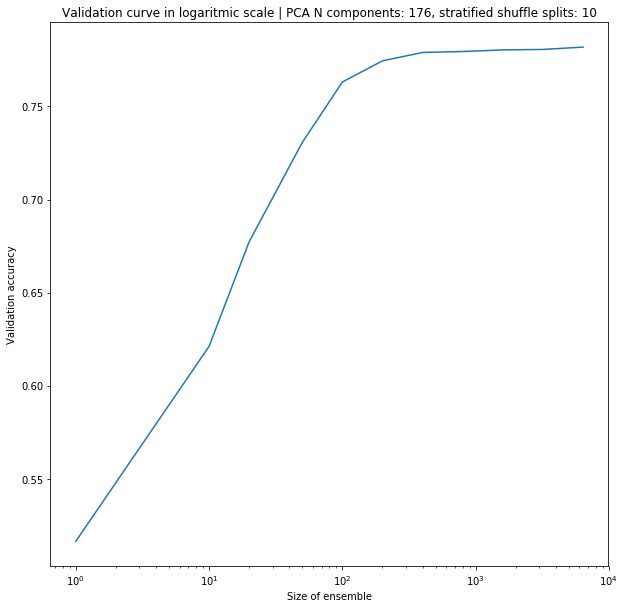

In [14]:
# Plot the validation curve
plt.figure(figsize=(10, 10), )
plt.semilogx(df.rf__n_estimators, df.validation_accuracy)
plt.title('Validation curve in logaritmic scale | PCA N components: 176, stratified shuffle splits: 10')
plt.xlabel('Size of ensemble')
plt.ylabel('Validation accuracy')
plt.show()

Note that the validation accuracy for a size of ensemble of one tree is only 51% but was around 66% in our decision tree model. It is because random forest go a step further than bagging by forcing each tree to be different than the previous one (at each split, the split can be done only on a randomly drawn subset of the predictors). As a result, random forest build a forest of heterogeneous/decorralated trees; the strongest predictors are not always at the top of the trees and so, about 20 trees are necessary to obtain a better accuracy than our decision tree model.

However, as we can see, with the number of trees increasing, the validation accuracy is drastically improved and reach an accuracy around 78% (same score as our kNN model). It is an amazing improvement !

Even if the accuracy seems to increase monotonically with the size of ensemble, 800 trees are probably enough.

### Random forest accuracy on the test set

Random forest accuracy on test set with these hyperparameters:
* PCA n components: 176
* Size of ensemble: 800
* Max depth: None
* Max features split: sqrt (same as auto)
* Criterion: Gini

In [15]:
if RUN_CALCULATION | (os.path.exists(FOREST_MODEL_FILEPATH) == False):
    
    # Pipeline estimator
    forest_model = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=176, random_state=0)),
        ('rf', RandomForestClassifier(n_estimators=800, max_depth=None, criterion='gini', max_features='sqrt', random_state=0, n_jobs=-1))
    ])

    # Fit model on the full train set
    forest_model.fit(X_train, y_train)
    
    # Save model in a numpy file
    np.save(FOREST_MODEL_FILEPATH, forest_model)
else:
    # Load the grid scores results from file
    forest_model = np.load(FOREST_MODEL_FILEPATH, allow_pickle=True).item(0)
    
# Evaluate accuracy on the test set
test_accuracy = forest_model.score(X_test, y_test)
print('Random forest accuracy (test set): {:.3f}'.format(test_accuracy))

Random forest accuracy (test set): 0.781


We obtain a test accuracy of 78% as expected from the validation accuracy obtained during the hyperparameters tuning.